# 30 Day Forecasts of US Daily New COVID-19 Cases Using ARIMA

At the time of writing this, 28,212,548 cases of COVID-19 have been reported in the USA. Flustered with what is seemingly an endless pandemic, I am putting my data science skills to the test to see if I can predict the trajectory of this public health crisis over the next 30 days.

To dos o, I will be using time series data of US daily new COVID-19 cases made publicly available by Johns Hopkins University: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series. Data is imported and manipulated, checked for stationarity. Autocorrelation and partial autocorrelation function plots are created to get a sense of how observations are correlated, grid search is conducted find optimized parameters for prediction, and an AutoRegressive Integrated Moving Average (ARIMA) model is used to test and predict 30 day forecasts of daily new COVID-19 cases in the United States.

The results indicate that ARIMA may not be the best model for this particular prediction task, although the general trend of the last 30 days is captured after achieving stationarity and optimizing for optimal autoregressive and moving average parameters.

### Import and Visualize Data from Johns Hopkins University CSSE COVID-19 dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#URL to public covid data from Johns Hopkins
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

#Pandas can read from the url directly
us_covid_data = pd.read_csv(url)

us_covid_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,6071,6079,6092,6117,6121,6143,6172,6203,6228,6248
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,19324,19361,19392,19433,19461,19554,19635,19670,19698,19714
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2057,2061,2067,2070,2074,2084,2095,2099,2106,2113
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2405,2411,2414,2416,2417,2432,2437,2442,2445,2449
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,6008,6021,6040,6042,6043,6058,6072,6086,6084,6095


The data provided by Johns Hopkins gives the cumulative case count for each state on each day since the pandemic started. I am only interested in new cases daily nationwide, so I transpose the rows, sum over columns, and difference the data. The index is also converted to pd.DatetimeIndex, so that the model can make use of it.

In [3]:
# Want daily new cases only... transpose rows, cut off unnecessay rows, sum over columns and use .diff() to convert cumulative cases to daily new cases
complete_new_daily_cases = us_covid_data.T.iloc[11:].sum(axis=1, skipna=True).diff().dropna()
#Convert index to datetime
complete_new_daily_cases.index = pd.to_datetime(complete_new_daily_cases.index)

complete_new_daily_cases.tail()

2021-02-23    71436.0
2021-02-24    74502.0
2021-02-25    77291.0
2021-02-26    73006.0
2021-02-27    68071.0
dtype: float64

To test the ARIMA model later, the last 30 days are split off. new_daily_cases_train contains dates from the start up until 1/17/2021, test_set, contains dates form 1/28/2021 until 2/26/2021, and complete_new_daily_cases contains every observation.

In [4]:
test_set = complete_new_daily_cases[-30:]
new_daily_cases_train = complete_new_daily_cases[:-30]
new_daily_cases_train

2020-01-23         0.0
2020-01-24         1.0
2020-01-25         0.0
2020-01-26         3.0
2020-01-27         0.0
                ...   
2021-01-24    130811.0
2021-01-25    151062.0
2021-01-26    146670.0
2021-01-27    152606.0
2021-01-28    168630.0
Length: 372, dtype: float64

And here is a simple visualization of the USA daily new Covid-19 case count:

Text(0.5, 1.0, 'USA Daily New COVID-19 Cases')

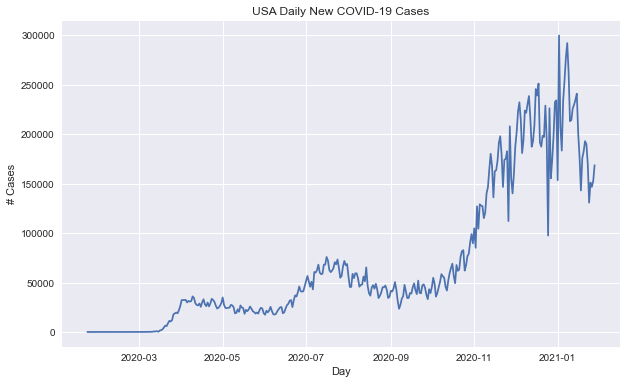

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
style.use('seaborn')

ax.plot(new_daily_cases_train)
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("USA Daily New COVID-19 Cases")

### Check for Stationarity (Manually & with Dickey Fuller test)

Before training an ARIMA model on the data, the data needs to be checked for stationarity, meaning that the data has has stable statistics, such as constant means and variances, over time.
This is because, otherwise, the timeseries is essentially equivalent to a white noise, carrying little information. Stationarity helps to ensure that behavior observed in a particular window of the data is likely to happen again, which is why many statistical models depend on it.

When manually checking for stationarity, the pandas rolling method helps make it easy to calculate various summary statistics. Calculating the rolling mean and standard deviation this way loses the first few observations of data, but those points aren't crucial for this task.

In [6]:
rolling_avg = new_daily_cases_train.rolling(window=7).mean().dropna()
rolling_std_dev = new_daily_cases_train.rolling(window=7).std().dropna()

Now the various statistics are plotted to check for stationarity manually:

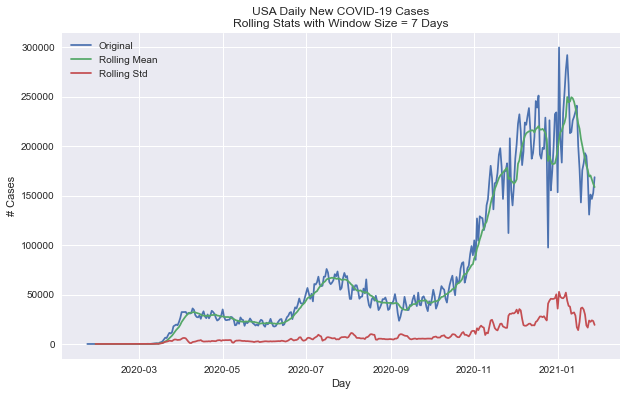

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
style.use('seaborn')

ax.plot(new_daily_cases_train, label="Original")
ax.plot(pd.Series(rolling_avg, index=new_daily_cases_train.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std_dev, index=new_daily_cases_train.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("USA Daily New COVID-19 Cases\n" + f"Rolling Stats with Window Size = {7} Days")
ax.legend()

The summary statistics do not pass the eye test for stationarity, as they all vary greatly over time, so the data needs to be made stationarity somehow. A common and effective method of doing so is by differencing the data, or subtracting the value of a previous observation with a current observation. If that successfully makes the timeseries stationary, predictions on data can be made and transformed back to the same scale. Furthermore, because the COVID data tails off and is non-zero, stationarity can be better achieved by taking the log return of the data, which is done below.

In [8]:
#Irregulaties where daily case count is 0... Add one to those days to avoid log returns of infinity
log_ret_input = new_daily_cases_train.copy()
log_ret_input[log_ret_input==0]+=1

log_ret = np.log(log_ret_input).diff().dropna()
rolling_log_avg = log_ret.rolling(window=7).mean().dropna()
rolling_log_std_dev = log_ret.rolling(window=7).std().dropna()

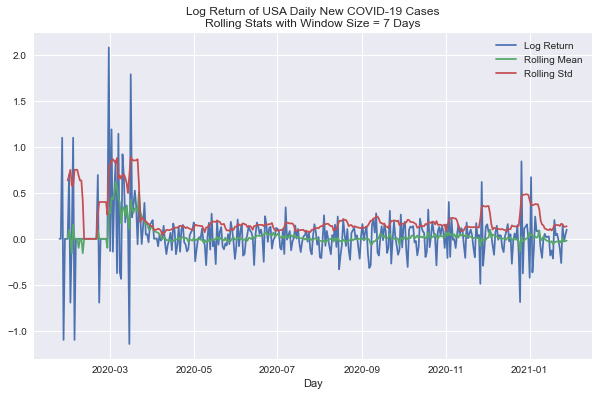

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
style.use('seaborn')

ax.plot(log_ret, label="Log Return")
ax.plot(pd.Series(rolling_log_avg, index=log_ret.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_log_std_dev, index=log_ret.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_title("Log Return of USA Daily New COVID-19 Cases\n" + f"Rolling Stats with Window Size = {7} Days")
ax.legend()

From just the visualization, the log return is much more stationary that the un-differenced dataset.The mean has been virtually removed, although there is some degree of variance in the data. So is there a more mathematical way to classify this log return as stationary

The Augmented Dickey-Fuller Unit test helps do just that: the ADF tests the null hypothesis that the data is not stationary. A p-value is provided that can be used to test stationarity against your preferred significance threshold.

In [10]:
# An example of performing an Augmented Dickey-Fuller unit root test

from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(log_ret)
print(f"p-value: {pval}")

p-value: 0.00506597891639453


The statsmodels library makes conducting the test easy, and with a p-value of 0.005, we can see that the log return is sginificant below the 1% threshold. Hence, the log return is stationary.

### Autocorrelation and Partial Autocorrelation

The ARIMA model that will be used for forecasting takes 3 parameters:

    p: number of autoregressive terms (AR order), can be identified by PACF plot
    d: number of nonseasonal differences (differencing order), 1st order differencing already achieved stationarity
    q: number of moving-average terms (MA order), can be identified by ACF plot

The differencing order was already identified as one, since that's all that was needed to achieve stationarity. To assist in finding p and q, ACF and PACF plots are created.

Text(0, 0.5, 'Correlation')

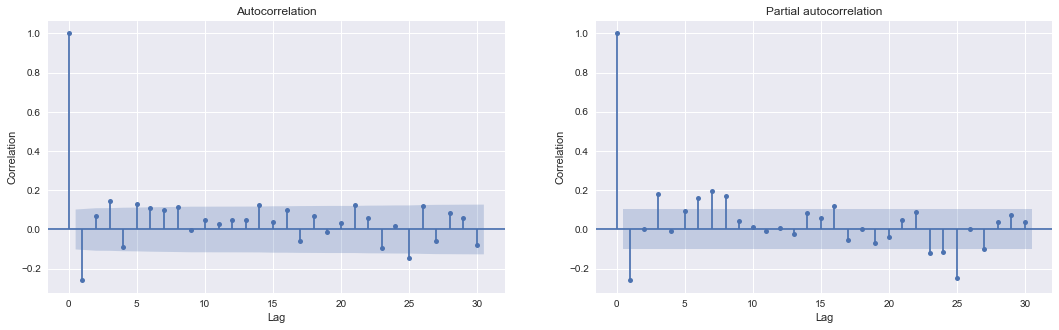

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
style.use('seaborn')

plot_acf(log_ret, ax=ax1, lags = range(0,31))
ax1.set_title('Autocorrelation')
ax1.set_xlabel(r"Lag")
ax1.set_ylabel(r"Correlation")

plot_pacf(log_ret, ax=ax2, lags = range(0,31))
ax2.set_title('Partial autocorrelation')
ax2.set_xlabel(r"Lag")
ax2.set_ylabel(r"Correlation")


The autocorrelation function gives the effect that *all previous points* in time together have on the current point. Hence, the moving average term q can be derived. 25 is the highest amount of lags that have a significant effect on the current observation, so analysis of the ACF would say that q is the optimal value, but the spikes at lag orders of 21, 14, and 8 should also be considered for tuning in the grid seach to be done.

The partial autocorrelation function gives the *direct* effect that each of the previous points have on the current observation. Analysis of the PACF would say that 25 is also an appropriate p value, as that's the furthest value back to consider that has a significant effect, but the lag orders of 24, 23, 16, and 8 are also significant.

### Grid Search

To get a more mathematical second opinion, a grid search can be run to iterate over p an q values and select the best parameter pair based off of the AIC score, which estimates out-of-sample prediction error. A low AIC score is generally considered better and indicates how well a model fits the data without overfitting, so the grid search seeks to optimize the AIC score. The code for running a simple grid search is below.

In [12]:
# grid search ARIMA parameters for time series
import warnings
from statsmodels.tsa.arima.model import ARIMA

# evaluate an ARIMA model for a given order (p,d,q)

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_aic, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order).fit()
                    aic = model.aic
                    if aic < best_aic:
                        best_aic, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_aic))
    return best_cfg 

#Arima does the differencing, so I only need the logged timeseries
log_train_undifferenced = new_daily_cases_train.copy()
log_train_undifferenced[log_train_undifferenced==0]+=1
log_train_undifferenced = np.log(log_train_undifferenced)
    
# evaluate parameters
p_values = [0,1,3,6,7,8,16,23,24,25,27] #Only selecting values above significance threshold to save time
d_values = [1]
q_values = [0,1,3,5,8,14,21,25]
warnings.filterwarnings("ignore")
optimal_order_train = evaluate_models(log_train_undifferenced, p_values, d_values, q_values)

ARIMA(0, 1, 0) AIC=127.390
ARIMA(0, 1, 1) AIC=110.092
ARIMA(0, 1, 3) AIC=102.662
ARIMA(0, 1, 5) AIC=91.097
ARIMA(0, 1, 8) AIC=75.281
ARIMA(0, 1, 14) AIC=79.351
ARIMA(0, 1, 21) AIC=61.511
ARIMA(0, 1, 25) AIC=55.990
ARIMA(1, 1, 0) AIC=106.708
ARIMA(1, 1, 1) AIC=108.639
ARIMA(1, 1, 3) AIC=74.588
ARIMA(1, 1, 5) AIC=66.338
ARIMA(1, 1, 8) AIC=70.230
ARIMA(1, 1, 14) AIC=62.923
ARIMA(1, 1, 21) AIC=102.354
ARIMA(1, 1, 25) AIC=49.727
ARIMA(3, 1, 0) AIC=95.906
ARIMA(3, 1, 1) AIC=76.863
ARIMA(3, 1, 3) AIC=77.761
ARIMA(3, 1, 5) AIC=69.508
ARIMA(3, 1, 8) AIC=66.040
ARIMA(3, 1, 14) AIC=58.201
ARIMA(3, 1, 21) AIC=52.612
ARIMA(3, 1, 25) AIC=44.488
ARIMA(6, 1, 0) AIC=86.266
ARIMA(6, 1, 1) AIC=65.780
ARIMA(6, 1, 3) AIC=64.912
ARIMA(6, 1, 5) AIC=53.233
ARIMA(6, 1, 8) AIC=54.426
ARIMA(6, 1, 14) AIC=52.467
ARIMA(6, 1, 21) AIC=49.167
ARIMA(6, 1, 25) AIC=47.065
ARIMA(7, 1, 0) AIC=72.906
ARIMA(7, 1, 1) AIC=64.852
ARIMA(7, 1, 3) AIC=67.337
ARIMA(7, 1, 5) AIC=51.944
ARIMA(7, 1, 8) AIC=49.713
ARIMA(7, 1, 14) AIC=

### Test Run ARIMA Model on Last 30 Days.

Using the p, d, and q values of 16, 1, and 25 found from the grid search, it's now time to train an ARIMA model and test its predictive power on the last 30 days. The ARIMA model makes use of autoregression, differencing, and moving averages to make predictions of future observations. The model does the differencing itelf, so the input to the model is the logged timeseries. The forecasts have to be reverted back to the same scale as the original timeseries with np.exp().

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import date, timedelta

def arima_log_ret(df, p, d, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    latest_date = (df[-1:].index + timedelta(days=1))[0]
    end_forecast = (df[-1:].index + timedelta(days=num_forecasts))[0]
    
    #Use the log returned time series...
    df[df==0]+=1
    logged_series = np.log(df)

    model = ARIMA(logged_series, order=(p,d,q))
    model_fit = model.fit()
    forecasts = model_fit.predict(start=latest_date,end=end_forecast,dynamic=True)
     
    #Reverse the log to get actual predicted case counts
    forecasts_n = np.exp(forecasts)

    return forecasts_n 

num_forecasts = 30
df = new_daily_cases_train
p, d, q = optimal_order_train
arima_log_ret(df, p, d, q, num_forecasts)

2021-01-29    141577.900828
2021-01-30    114287.633619
2021-01-31    100108.529649
2021-02-01     80870.039013
2021-02-02     95432.607128
2021-02-03     92089.696631
2021-02-04     78831.000937
2021-02-05     76067.842165
2021-02-06     60882.901502
2021-02-07     64691.289539
2021-02-08     50114.206878
2021-02-09     48358.531524
2021-02-10     54553.540165
2021-02-11     51613.882111
2021-02-12     52972.996411
2021-02-13     44666.168596
2021-02-14     41270.360056
2021-02-15     39594.489119
2021-02-16     40534.333149
2021-02-17     46441.868391
2021-02-18     43746.459429
2021-02-19     47932.192482
2021-02-20     44487.568236
2021-02-21     40218.660383
2021-02-22     39175.838507
2021-02-23     37352.288597
2021-02-24     47506.959724
2021-02-25     47682.252057
2021-02-26     47582.039464
2021-02-27     47072.903517
Freq: D, Name: predicted_mean, dtype: float64

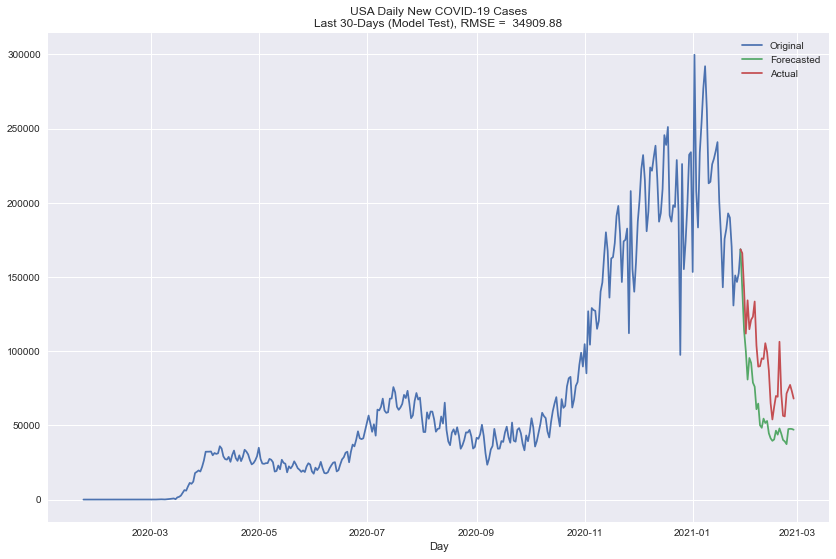

In [14]:
p, d, q = optimal_order_train
num_forecasts=30
forecasts = arima_log_ret(new_daily_cases_train, p,d,q, num_forecasts)
actual = test_set[:num_forecasts]
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

style.use('seaborn')

fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(new_daily_cases_train, label="Original")
ax.plot(new_daily_cases_train[-1:].append(forecasts), label="Forecasted")
ax.plot(new_daily_cases_train[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("USA Daily New COVID-19 Cases\n" + f"Last {len(forecasts)}-Days (Model Test), RMSE = {rmse: .2f}")
ax.legend()

The ARIMA model was able to predict the downward trend, as well as the timing of the relative highs and lows fairly well, although the accuracy of the actual estimates undershot the actual observations. The root mean square error indicates that most observations fell within roughly 35,000 cases of the predicted values, so despite the model being able to vaguely capture the trend, the accuracy was pretty low.

### Future 30 Day Forecast

Now what about 30 days into the future, February 28th to March 29th at the time of writing? Because a month of data has been collected since then, the process of selecting p and q will be repeated again before making predictions.

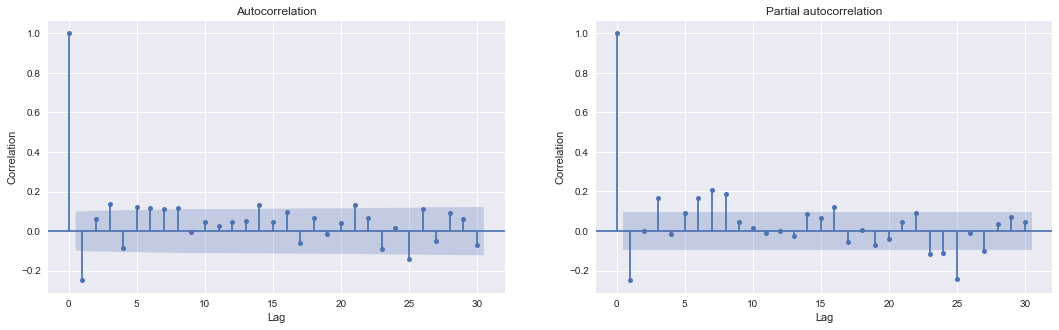

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

timeseries_complete = complete_new_daily_cases.copy()
timeseries_complete[timeseries_complete==0]+=1
logged_timeseries_complete = np.log(timeseries_complete).diff().dropna()

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
style.use('seaborn')

plot_acf(logged_timeseries_complete, ax=ax1, lags = range(0,31))
ax1.set_title('Autocorrelation')
ax1.set_xlabel(r"Lag")
ax1.set_ylabel(r"Correlation")

plot_pacf(logged_timeseries_complete, ax=ax2, lags = range(0,31))
ax2.set_title('Partial autocorrelation')
ax2.set_xlabel(r"Lag")
ax2.set_ylabel(r"Correlation")

plt.show()

With nearly identical ACF/ PACF charts as the last time, the following p, d, and q values will be considered when performing grid search, as they are above the significance thresholds:

    p = [0,1,3,6,7,8,16,23,24,25,27]
    d = [1]
    q = [0,1,3,5,6,7,8,14,21,25]

In [16]:
# grid search ARIMA parameters for time series
timeseries = complete_new_daily_cases.copy()
timeseries[timeseries==0]+=1
logged_timeseries = np.log(timeseries)

p_values = [0,1,3,6,7,8,16,23,24,25,27] #Only selecting values above significance threshold to save time
d_values = [1]
q_values = [0,1,3,5,6,7,8,14,21,25]
warnings.filterwarnings("ignore")
optimal_order_complete = evaluate_models(logged_timeseries, p_values, d_values, q_values)

ARIMA(0, 1, 0) AIC=117.908
ARIMA(0, 1, 1) AIC=99.892
ARIMA(0, 1, 3) AIC=93.847
ARIMA(0, 1, 5) AIC=81.508
ARIMA(0, 1, 6) AIC=64.423
ARIMA(0, 1, 7) AIC=60.626
ARIMA(0, 1, 8) AIC=61.711
ARIMA(0, 1, 14) AIC=63.887
ARIMA(0, 1, 21) AIC=46.282
ARIMA(0, 1, 25) AIC=37.270
ARIMA(1, 1, 0) AIC=96.754
ARIMA(1, 1, 1) AIC=98.703
ARIMA(1, 1, 3) AIC=63.107
ARIMA(1, 1, 5) AIC=53.103
ARIMA(1, 1, 6) AIC=54.719
ARIMA(1, 1, 7) AIC=62.153
ARIMA(1, 1, 8) AIC=56.608
ARIMA(1, 1, 14) AIC=47.217
ARIMA(1, 1, 21) AIC=47.609
ARIMA(1, 1, 25) AIC=29.583
ARIMA(3, 1, 0) AIC=87.523
ARIMA(3, 1, 1) AIC=89.300
ARIMA(3, 1, 3) AIC=64.836
ARIMA(3, 1, 5) AIC=57.830
ARIMA(3, 1, 6) AIC=52.517
ARIMA(3, 1, 7) AIC=65.402
ARIMA(3, 1, 8) AIC=60.296
ARIMA(3, 1, 14) AIC=41.730
ARIMA(3, 1, 21) AIC=26.415
ARIMA(3, 1, 25) AIC=22.888
ARIMA(6, 1, 0) AIC=76.864
ARIMA(6, 1, 1) AIC=52.031
ARIMA(6, 1, 3) AIC=50.976
ARIMA(6, 1, 5) AIC=34.350
ARIMA(6, 1, 6) AIC=38.717
ARIMA(6, 1, 7) AIC=35.997
ARIMA(6, 1, 8) AIC=32.004
ARIMA(6, 1, 14) AIC=31.328
A

16, 1, and 21 were found to be the most optimal p, q, and d values for the updated timeseries data, so those will be plugged into the model.

In [17]:
num_forecasts = 30
df = complete_new_daily_cases
p, d, q = optimal_order_complete
forecasts_complete = arima_log_ret(df, p, d, q, num_forecasts)
forecasts_complete

2021-02-28    56779.679022
2021-03-01    56191.979485
2021-03-02    57873.233713
2021-03-03    54362.568007
2021-03-04    51353.238540
2021-03-05    49037.571554
2021-03-06    43493.727089
2021-03-07    37099.169240
2021-03-08    31607.115085
2021-03-09    38423.109448
2021-03-10    36186.369096
2021-03-11    42128.362057
2021-03-12    37733.955675
2021-03-13    33741.801015
2021-03-14    29343.644141
2021-03-15    25117.611360
2021-03-16    27427.931524
2021-03-17    30483.948376
2021-03-18    28795.596415
2021-03-19    33311.989729
2021-03-20    30247.597586
2021-03-21    27283.596756
2021-03-22    24565.281790
2021-03-23    27934.614763
2021-03-24    29418.051293
2021-03-25    29601.817494
2021-03-26    30582.765687
2021-03-27    28676.111905
2021-03-28    25561.020607
2021-03-29    26379.860669
Freq: D, Name: predicted_mean, dtype: float64

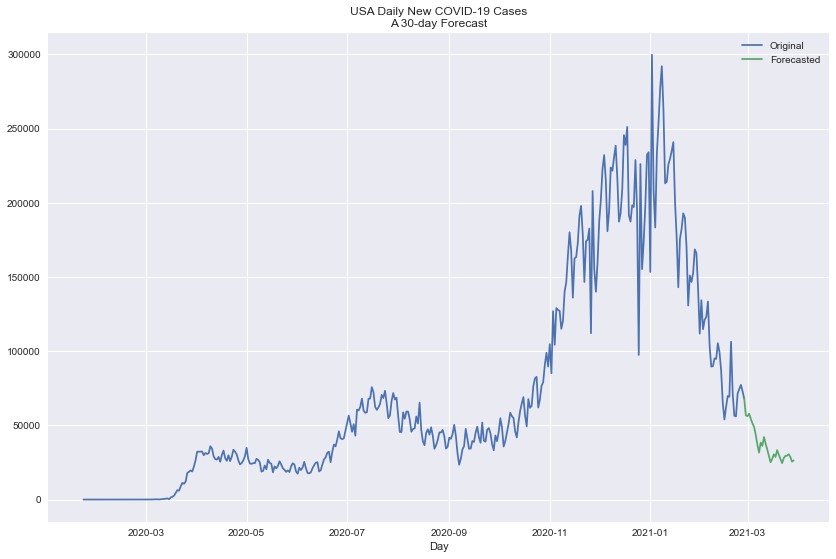

In [18]:
style.use('seaborn')
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(complete_new_daily_cases, label="Original")
ax.plot(complete_new_daily_cases[-1:].append(forecasts_complete), label="Forecasted")
ax.set_xlabel("Day")
ax.set_title("USA Daily New COVID-19 Cases\n" + f"A {len(forecasts)}-day Forecast")
ax.legend()

Excexllent! I am glad to see the trend is still downward, but what about the uncertainty behind the model? The statsmodel library used for ARIMA makes it easy to quickly create prediction intervals.

(0.0, 350000.0)

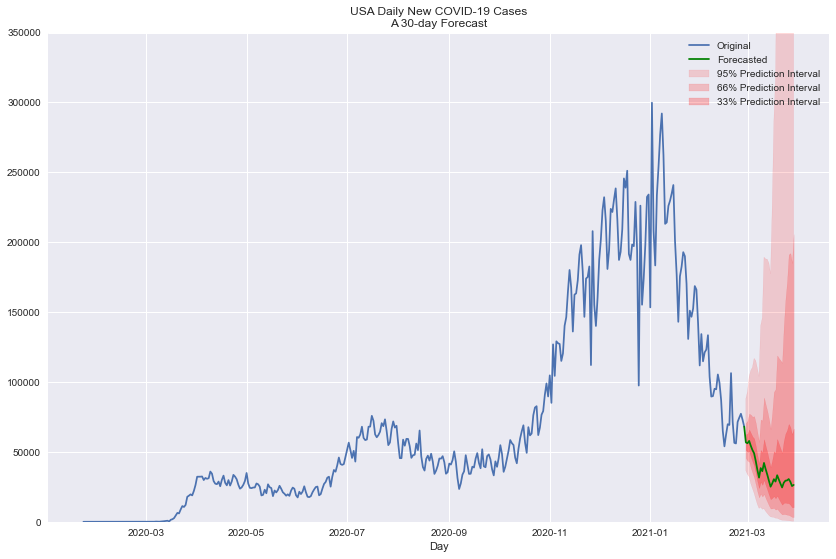

In [19]:
num_forecasts = 30
p, d, q = optimal_order_complete
df = complete_new_daily_cases
df[df==0]+=1
loggeded_df = np.log(df)
arima = ARIMA(loggeded_df, order=(p,d,q)).fit()
PredictionResultsWrapper = arima.get_forecast(steps=num_forecasts, dynamic=True)
Forecast = np.exp(PredictionResultsWrapper.predicted_mean)
ci_95 = np.exp(PredictionResultsWrapper.conf_int(alpha=.05))
ci_66 = np.exp(PredictionResultsWrapper.conf_int(alpha=.33))
ci_33 = np.exp(PredictionResultsWrapper.conf_int(alpha=.66))

style.use('seaborn')
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(complete_new_daily_cases, label="Original")
ax.plot(complete_new_daily_cases[-1:].append(Forecast), label="Forecasted", color='green')
ax.fill_between(ci_95.index,
                ci_95.iloc[:, 0],
                ci_95.iloc[:, 1], color='r', alpha=.15, label='95% Prediction Interval')
ax.fill_between(ci_66.index,
                ci_66.iloc[:, 0],
                ci_66.iloc[:, 1], color='r', alpha=.2, label='66% Prediction Interval')
ax.fill_between(ci_33.index,
                ci_33.iloc[:, 0],
                ci_33.iloc[:, 1], color='r', alpha=.25, label='33% Prediction Interval')
ax.set_xlabel("Day")
ax.set_title("USA Daily New COVID-19 Cases\n" + f"A {len(forecasts)}-day Forecast")
ax.legend()
plt.ylim(0,350000)

And the hard truth is revealed: the vast prediction intervals imply that there is a great deal of uncertainty behind using ARIMA as an approach for this particular prediction task, even at the 33% level. Perhaps, the model would do better if seasonality was taken into consideration, but even after ensuring stationarity and optimizing the autoregressive and moving average values, basic ARIMA isn't well-suited for predicting daily cases of COVID-19. Deep-learning or other more complex, powerful machine learning learning methods may be better for a task of this magnitude. Nonetheless, it is still interesting to apply basic timeseries analysis and forecasting principles and see how they hold up to one of the most topical prediction tasks today.